In [1]:
import json
import pandas as pd
pd.options.mode.chained_assignment = None
from tqdm import tqdm
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
import pandas as pd

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
import numpy as np
np.random.seed(0)

from tqdm import tqdm
import random

# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set_theme(style="white", palette="pastel")
import scipy
import json

from scipy import sparse

import time
import gc

In [2]:
data_dir = '2021-07-19'

In [3]:
papers = pd.read_csv(f'scibert_encoded_papers/valid_metadata_{data_dir}.csv',sep='\t').set_index('cord_uid')[['title','journal','publish_time']].sort_values('publish_time')

In [4]:
jrnls = Counter(papers['journal']).most_common(100)

In [7]:
Counter(papers['journal']).most_common()

[('Int J Environ Res Public Health', 1107),
 ('J Med Virol', 566),
 ('medRxiv', 553),
 ('PLoS One', 502),
 ('Int J Mol Sci', 412),
 ('bioRxiv', 404),
 ('Front Immunol', 370),
 ('Sci Rep', 365),
 ('Front Psychol', 362),
 ('Cureus', 317),
 ('J Clin Med', 305),
 ('BMJ Open', 294),
 ('Viruses', 277),
 ('MMWR Morb Mortal Wkly Rep', 270),
 ('Sensors (Basel)', 225),
 ('Molecules', 204),
 ('Nutrients', 199),
 ('Med Hypotheses', 191),
 ('Br J Surg', 186),
 ('BMC Public Health', 185),
 ('Vaccines (Basel)', 175),
 ('Int J Infect Dis', 174),
 ('Front Public Health', 171),
 ('J Infect', 161),
 ('J Med Internet Res', 158),
 ('BMJ Glob Health', 152),
 ('Dermatol Ther', 141),
 ('Int J Clin Pract', 134),
 ('Environ Sci Pollut Res Int', 134),
 ('Clin Microbiol Infect', 129),
 ('Heliyon', 126),
 ('BMC Health Serv Res', 124),
 ('Front Microbiol', 122),
 ('Front Pharmacol', 121),
 ('Disaster medicine and public health preparedness', 120),
 ('Healthcare (Basel)', 119),
 ('Clin Case Rep', 116),
 ('J Family M

In [40]:
selected = ['Int J Environ Res Public Health','Front Public Health','Br J Surg','Front Immunol','Int J Mol Sci','J Clin Med']

In [41]:
n_per_class = 50

In [42]:
samples = []
for jrnl in selected:
    df = papers.loc[papers['journal']==jrnl].sample(n=n_per_class, random_state=0)
    samples.append(df)
samples = pd.concat(samples,axis=0)

In [43]:
samples['label'] = list(map(lambda x:selected.index(x),samples['journal'].tolist()))

In [44]:
Y = samples['label']

In [45]:
models_scores = dict()
for method in ['TF-IDF','Glove','SciBert']:
    # method = 'scibert'
    # method = 'tfidf'
    # SCIBERT Embedding
    if method == 'SciBert':
        print('SciBert')
        title_embs_df = pd.read_csv(f'scibert_encoded_papers/title_embs_df_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'scibert_encoded_papers/abstract_embs_df_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]

    # Glove Embedding
    if method == 'Glove':
        print('Glove')
        title_embs_df = pd.read_csv(f'title_embs_df_glove_{data_dir}.csv',index_col=0)
        abstract_embs_df = pd.read_csv(f'abstract_embs_df_glove_{data_dir}.csv',index_col=0)
        paper_emb = title_embs_df.join(abstract_embs_df,lsuffix='_ti',rsuffix='_ab')
        uid_map = {uid:i for i,uid in enumerate(title_embs_df.index)}
        X = paper_emb.values[list(map(lambda x:uid_map[x],samples.index.tolist()))]


    # TF-IDF Embedding
    if method == 'TF-IDF':
        print('TF-IDF')
        values = scipy.sparse.load_npz(f'tf-idf-results/values_{data_dir}_scibert_token.npz')
        index = json.load(open(f"tf-idf-results/index_{data_dir}_scibert_token",'r',encoding='utf-8'))
        column = json.load(open(f"tf-idf-results/column_{data_dir}_scibert_token",'r',encoding='utf-8'))
        # paper_emb = pd.DataFrame.sparse.from_spmatrix(values,columns=column,index=index)
        uid_map = {uid:i for i,uid in enumerate(index)}
        X = values[list(map(lambda x:uid_map[x],samples.index.tolist()))]
    

    clf = RandomForestClassifier()
    models_scores[method] = cross_validate(clf, X, Y, cv=5,
                             scoring=('f1_micro', 'f1_macro','neg_log_loss'),
                             return_train_score=True)

TF-IDF
Glove
SciBert


In [46]:
data = []
for k,v in models_scores.items():
    for i in range(5):
        data.append([k,'Test Micro F1',v['test_f1_micro'][i]])
    for i in range(5):
        data.append([k,'Test Macro F1',v['test_f1_macro'][i]])
#     for i in range(5):
#         data.append([k,'test_neg_log_loss',v['test_neg_log_loss'][i]])

In [47]:
data_df = pd.DataFrame(data,columns=['method','metric','value'])

In [59]:
df = pd.concat([data_df.groupby(['method','metric']).apply(lambda x: x.mean()), data_df.groupby(['method','metric']).apply(lambda x: x.std())], axis=1)

c:\users\86187\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [66]:
df.columns = ['Mean', 'Std']

In [69]:
# df

In [71]:
df.round(4).to_excel('jrnl_clf.xlsx')

In [14]:
# iris_df = sns.load_dataset('iris')

In [28]:
# data_df

In [15]:
# iris_df

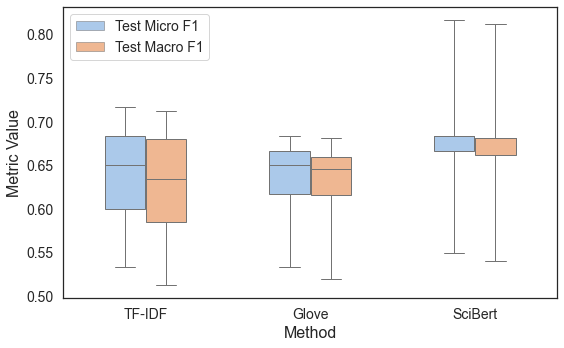

In [52]:
# Grouped violinplot
plt.figure(figsize=(8,5))
sns.boxplot(x='method', y='value',hue="metric", data=data_df, width=0.5, linewidth=1.,whis=8)
# sns.catplot(x='method', y='value',hue="metric", data=data_df, linewidth=1,height=4, aspect=.7, palette="Set3")
# sns.swarmplot(x='method', y='value',hue="metric", data=data_df,palette="Blues")

plt.legend(loc='upper left',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Metric Value',fontsize=16)
plt.xlabel('Method',fontsize=16)
# plt.show()
plt.tight_layout()
plt.savefig('Jrnl_Classification.png',dpi=300)

In [17]:
# scores

In [18]:
# print(scores['test_f1_micro'])
# print(scores['test_f1_macro'])
# print(scores['test_neg_log_loss'])